![alt text](https://www.msengineering.ch/typo3conf/ext/msengineering/Resources/Public/Images/Logo/mse-full.svg "MSE Logo") 

# AnTeDe Practical Work 8: Name Generation with RNN

by Fabian Märki

## Summary
The aim of this lab is to get an understanding of building a RNN model using Keras. The task is to train a character-level language models that generates new baby names (but feel free to change this to e.g. new start-up names or city names etc.). 

### Source
- https://github.com/JKH4/name-generator/blob/master/dev/2018-05-18_JKH_NameGen-Main.ipynb

This lab contains assigments (although most of the code is given). <font color='red'>Questions are written in red.</font>

In [65]:
from __future__ import print_function
import numpy as np
import pandas as pd
import random
import sys
import io
import os
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import itertools

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GRU, SimpleRNN, Bidirectional, InputLayer
from keras.optimizers import Adam
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from more_itertools import sort_together

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    print("Run on GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    #config.gpu_options.per_process_gpu_memory_fraction = 0.4

### Your Task

Below you find working code that needs some improvement.

<font color='red'>Your task is to get hands on experience with Keras and RNNs by trying different options on how to build a RNN and on how to tune it. 
<br>After you created a model with good performance, please write a short summary about your experience: what works well, what did not work well, what influenced the performance of the model, did you experience strange behaviors, how did you analyze the data, how do you estimate the performance of your model, what possible further improvements you can consider.</font>

<font color='red'>Modify the function `create_model` according your intuition on how the model could be improved. Options you might want to try (please experiment with at least four of them):</font>

- try different RNN types (SimpleRNN, LSTM, GRU - see [here](https://keras.io/layers/recurrent))
- try different number of RNN units (see `parameters`)
- use regularization techniques (e.g. dropout)
- use options provided by the RNN types (e.g. arguments "dropout" and "recurrent_dropout" - see [here](https://keras.io/layers/recurrent))
- stack several RNN layers (see [here](https://keras.io/getting-started/sequential-model-guide/) and search for "Stacked LSTM for sequence classification")
- try different optimizers (see [here](https://keras.io/optimizers/))
- get more inspiration from [here](https://ruder.io/deep-learning-nlp-best-practices)

You might also want to have a look at the `parameters` variable below and modify it according your needs.</font> 

### Results
Experiments that were done:
* different RNN types
* different number of RNN units
* regularization techniques (dropout / recurrent_dropout)
* stack several RNN layers

> The code has been modified so that the experiments above were able to be conducted.

#### Different RNN Types
* Types tried: SimpleRNN, LSTM, GRU (other params stayed the same as in default configuration)
* Expectation: 
    * SimpleRNN should perform worst since they are not able to capture the longer structure of the sequence, thus should result in better performance for shorter names than longer ones. 
    * LSTM should perform the best since it will be able to capture long and short term relations, thus resulting in the best overall performance.
    * GRU should perform well and should be able to be trained a lot faster than the LSTM.
* Results:
    * The accuracy of the LSTM and GRU were $\approx 2-3 \%$ higher than the SimpleRNN, which was as expected, even though the difference was expected to be much larger.
    * The training time of the GRU was slightly faster, but only by 0.5 seconds, which was not as expected. This may be caused that only one RNN layer was used with a fairly low number of units.
    
#### Different Number of RNN units
* Experiment Setup:
    * `rnn_types = ['SimpleRNN', 'LSTM', 'GRU']`
    * `rnn_units = [8, 32, 64, 128]`
    * the product of the two lists were trained
* Expectation:
    * The larger the number of RNN units, the better the performance in all types.
    * The performance difference between the SimpleRNN and the LSTM and GRU should be higher when using more units.
* Results:
    * GRU and LSTM show very similar performance on every different unit size.
    * the difference between SimpleRNN and LSTM and GRU is getting larger and larger when using more units.
    * the performance of the GRU and LSTM get better when using more units.
    * interestingly, the SimpleRNN does not get better when using more units; it gets worse. This can be caused that the model would need some longer time to converge than the other two types.
    
#### Regularization Techniques
* Experiment Setup:
    * `dropout_rates = [0.0, 0.1, 0.3, 0.5]`
    * `parameters['rnn_type'] = 'GRU'`
    * `parameters['rnn_units'] = 128`
    * the same rates were used for `dropout` and `recurrent_dropout`
    * the model stayed the same, but the dropout rate was changed
    * for this experiment, a model with many units was chosen because it is likely that these will suffer from overfitting
* Expectation:
    * the more dropout is applied, the worse the performance, but the better the generalisation error.
    * the `recurrent_dropout` should work better than the `dropout` since the regular one can lead to the loss of long term relationships.
* Results:
    * the regular `dropout` performance degrades a lot faster than when using the recurrent one.
    * models trained using a high `recurrent_dropout` remain a high accuracy.
    * the higher the dropout rate is, the more nonsense the names get.
    
#### Stack several layers
* Experiment Setup:
    * `stacks = [1, 2, 3, 4]`
    * `base_unit = [64]`
    * `parameters['rnn_type'] = 'GRU'`
    * `parameters['dropout'] = 0.0`
    * `parameters['recurrent_dropout'] = 0.2`
    * the model was fixed, including the number of units to use in each layer
    * different stacks were trained (e.g. 1-4)
* Expectation:
    * The more stacks the model has the better the resulting performance.
* Results:
    * The expecation was tottaly wrong, the more stacks there were, the worser the performance. This is a really strange behavior, which I can't explain. Maybe they would need longer training.

In [60]:
def create_model(parameters):
    length_of_sequence = parameters["trainset_infos"]['length_of_sequence']
    number_of_chars = parameters["trainset_infos"]['number_of_chars']
    
    model = Sequential()
    model.add(InputLayer(input_shape=(length_of_sequence, number_of_chars)))
    
    for index, unit in enumerate(parameters["rnn_units"]):
        is_last = index != len(parameters['rnn_units']) - 1
            
        if parameters["rnn_type"] == 'SimpleRNN':
            model.add(SimpleRNN(unit, 
                                dropout=parameters['dropout'], 
                                recurrent_dropout=parameters['recurrent_dropout'], 
                                return_sequences=is_last))
        elif parameters["rnn_type"] == 'LSTM':
            model.add(LSTM(unit, 
                           dropout=parameters['dropout'], 
                           recurrent_dropout=parameters['recurrent_dropout'], 
                           return_sequences=is_last))
        elif parameters["rnn_type"] == 'GRU':
            model.add(LSTM(unit, 
                           dropout=parameters['dropout'], 
                           recurrent_dropout=parameters['recurrent_dropout'], 
                           return_sequences=is_last))
        
    if parameters['dropout'] > 0.0:
        model.add(Dropout(parameters['dropout']))
        
    model.add(Dense(number_of_chars, activation='softmax'))
    
    if parameters.get("verbose"):
        model.summary()
        
    return model

def load_data(parameters):
    length_of_sequence = 5
    padding_start = '#'
    padding_end = '*'
    file_url = parameters["file_url"]

    text = ''
    with io.open(get_file(os.path.basename(file_url), origin=file_url), encoding='utf-8') as f:
        text = f.read().lower()

    names = pd.read_csv(io.StringIO(text), names=['name'], comment='#', header=None, keep_default_na=False, na_values=[])
    names['name'] = names['name'].map(lambda n: n.replace(padding_start, ''))    # replace characters used for training
    names['name'] = names['name'].map(lambda n: n.replace(padding_end, ''))    # replace characters used for training
    names['name'] = names['name'].map(lambda n: padding_start + n + padding_end) 
    
    data_dict = {}
    data_dict['name_list'] = names['name']
    data_dict['char_list'] = sorted(list(set(data_dict['name_list'].str.cat() + '*')))
    data_dict['char_to_ix'] = { ch:i for i,ch in enumerate(data_dict['char_list']) }
    data_dict['ix_to_char'] = { i:ch for i,ch in enumerate(data_dict['char_list']) }
           
    # Extract target names to list (currently '#name*')
    training_names = data_dict['name_list'].tolist()
    
    # Extract padding characters
    padding_start = training_names[0][0]
    padding_end = training_names[0][-1]

    # Extract target character convertors
    # This will be used to convert a character to its "one hot index" and vice versa (cf Keras to_categorical())
    c2i = data_dict['char_to_ix']
    i2c = data_dict['ix_to_char']
    
    # Extract the target number of characters in all target names
    # This will be used to convert character index in its "one hot" representation (cf Keras to_categorical())
    number_of_chars = len(data_dict['char_list'])
    
    # Pad target names with enough (lengh_of_sequence) padding characters (result '##...##name**...**' )
    # The goal is  be sure that, for each name, the first training data is X[0] = '##...##'
    # and Y[0] = First actual character of the name
    training_names = [
        padding_start * (length_of_sequence - 1) + n + padding_end * (length_of_sequence - 1) for n in training_names
    ]

    # Init X and Y as list
    X_list = []
    Y_list = []

    # Init counter for visual feedback
    counter = 0 if parameters["verbose"] else None
    
    for name in training_names:
        # Slide a window on the name, one character at a time
        for i in range(max(1, len(name) - length_of_sequence)):
            # Extract the new sequence and the character following this sequence
            new_sequence = name[i:i + length_of_sequence]
            target_char = name[i + length_of_sequence]
            
            # Add the new sequence to X (input of the model)
            X_list.append([to_categorical(c2i[c], number_of_chars) for c in new_sequence])
            # Add the following character to Y (target to be predicted by the model)
            Y_list.append(to_categorical(c2i[target_char], number_of_chars))

        # visual feedback
        if parameters["verbose"]:
            counter += 1
            print(counter) if counter % 100 == 0 else print('.', end='')
            
    # make sure number of elements allignes with batch size
    offset = len(X_list) % parameters["batch_size"]
    if offset != 0:
        elements_to_copy = parameters["batch_size"] - offset
        X_list.extend(X_list[:elements_to_copy])
        Y_list.extend(Y_list[:elements_to_copy])
        
    # Convert X and Y to numpy array
    x_train = np.array(X_list)
    y_train = np.array(Y_list)
    
    # Extract the number of training samples
    m = len(x_train)
    
    # Create a description of the trainset
    parameters["trainset_infos"] = {
        'length_of_sequence': length_of_sequence,
        'number_of_chars': number_of_chars,
        'm': m,
        'padding_start': padding_start,
        'padding_end': padding_end,
    }

    print(
        '\n{} names split in {} training sequence of {} encoded chars !'.format(counter, m, length_of_sequence)
    ) if parameters["verbose"] else None

    # Visual feedbacks
    if parameters["verbose"]:
        print('X shape: {}'.format(x_train.shape))
        print('Y shape: {}'.format(y_train.shape))

        print('X[0] = {}'.format(x_train[0]))
        print('Y[0] = {}'.format(y_train[0]))

        print('Training set size: {}'.format(m))
        print('length_of_sequence: {}'.format(length_of_sequence))
        print('number_of_chars: {}'.format(number_of_chars))
        print('some names: {}'.format(names['name'][:5]))
    
                 
    parameters["x_train"] = x_train
    parameters["y_train"] = y_train
    parameters["word2index"] = c2i
    parameters["index2word"] = i2c                


def load_embeddings(word2index, word2embedding, embedding_dim, input_length = None, trainable=False):
    #return gensim_embedding_model.get_keras_embedding(train_embeddings=train_embeddings)
    
    embedding_matrix = np.zeros((len(word2index) + 1, embedding_dim))
    
    for word, i in word2index.items():
        embedding_vector = word2embedding.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            
    if input_length is None:
        return Embedding(len(word2index) + 1, 
                         embedding_dim,
                         weights=[embedding_matrix],
                         trainable=trainable)
    else:
        return Embedding(len(word2index) + 1, 
                         embedding_dim,
                         weights=[embedding_matrix],
                         input_length=input_length,
                         trainable=trainable)

def create_embedding(parameters):
    if parameters["embedding_use_pretrained"]:
        embedding_model = parameters["embedding_model"]
        word2embedding = {word: embedding_model[word] for word, vector in embedding_model.vocab.items()}
        embedding_dim = embedding_model.vector_size
        embedding_layer = load_embeddings(parameters["word2index"], word2embedding, embedding_dim)
        return embedding_layer
    else:
        return Embedding(parameters["max_words"], parameters["embedding_dim"], input_length=parameters["maxlen"])


def compile_model(model, parameters):
    optimizer = Adam(lr = parameters["learning_rates"][parameters["iter"]])

    model.compile(loss=parameters["loss_function"], optimizer=optimizer, metrics = parameters["metrics"])

        
def train_model(model, parameters):
    i = parameters["iter"]
    
    # Train the model
    h = model.fit(
        parameters["x_train"], parameters["y_train"],
        validation_data = parameters.get("validation_data"),
        batch_size = parameters["batch_size"],
        callbacks = parameters.get("callbacks"),
        initial_epoch = parameters["total_epochs"],
        epochs = parameters["total_epochs"] + parameters["epochs_to_run"][i],
        verbose=parameters['verbose']
    )

    history = parameters["history"]
    # Update history
    for key, val in h.history.items():
        col = history.get(key)
        
        if col is None:
            col = np.array([])
        
        history[key] = np.append(col, val)
        
    
    # Update the training session info
    parameters['total_epochs'] += parameters['epochs_to_run'][i]
    
    
def plot_class_balance(y, title=''):
    (unique, counts) = np.unique(y, return_counts=True)
    (unique, counts) = sort_together([unique, counts])

    plt.bar(unique, counts, align='center')
    plt.xticks(np.arange(len(unique)), unique)
    plt.xlabel('label')
    plt.ylabel('count')
    plt.title(title)

    plt.show()
    
    
def plot_confusion_matrix(y_true, y_pred, title=''):
    classes = list(set(list(y_true) + list(y_pred)))
    classes.sort()

    cmm = confusion_matrix(y_true, y_pred)

    print('Set Population: {}'.format(cmm.sum()))
    print('Accuracy: {:.4f}'.format(float(cmm.trace()) / cmm.sum()))

    plt.figure(figsize=(10, 8))
    plt.imshow(cmm / cmm.sum(), interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()

    plt.ylim(-0.5, len(classes)-0.5)

    if classes is not None:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45, size='x-large')
        plt.yticks(tick_marks, classes, size='x-large')

    for y in range(cmm.shape[0]):
        for x in range(cmm.shape[1]):
            if cmm[y, x] > 0:
                plt.text(x, y, '%.0i' % cmm[y, x],
                         horizontalalignment='center',
                         verticalalignment='center')
    plt.show()
    

def plot_training_session(parameters, plots=["accuracy", "val_accuracy"], title='Progress', show=True):
    history = parameters["history"]
    
    x = range(len(history[plots[0]]))
    
    for label in plots:
        vals = history.get(label)
        if vals is not None:
            plt.plot(x, vals, label = label)
        else:
            print("There is no data for", label)
    
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend()
    if show: plt.show()
    
def generate_name(model, parameters, start_char = None, name_max_length = 25):
    '''
    Generate some name with the RNN model
    
    ## Inputs:
    model (Keras model): 
    parameters (dict): the parameters
    name_max_length (integer): max size of the generated name
    verbose (boolean): show some feedbacks
    ## Outputs:
    generated_name (string): name generated by the RNN
    (probability, gap): few numbers about this generated name
        probability: probability to generate this name (cummulative probability to select each character)
        ecart: gap between best name and this name (cummulative sum of gaps between selected character and best character)
        
    '''
    trainset_infos = parameters["trainset_infos"]
    # Extract the number of unique character in trainset
    dict_size = trainset_infos["number_of_chars"]
    
    # Extract the size of an input sequence
    sequence_length = trainset_infos["length_of_sequence"]
    
    # Extract utils dictionnary to convert character to one hot index and vice versa
    # in this context 'word' is meant to be a character
    i2c = parameters["index2word"]
    c2i = parameters["word2index"]
    
    # Extract padding character
    padding_start = trainset_infos["padding_start"]
    
    # Init a name full of padding_start character
    generated_name = padding_start * (sequence_length + name_max_length)

    # Init counters
    probability = 1
    gap = 0

    if start_char is not None:
        generated_name = generated_name[:(sequence_length - 1)] + start_char + generated_name[sequence_length:]
    
    # Generate new character from current sequence
    for i in range(name_max_length):
        # Extract current sequence from generated character
        x_char = generated_name[i:i+sequence_length]
        
        # Convert current sequence to one hot vector
        x_cat = np.array([[to_categorical(c2i[c], dict_size) for c in x_char]])
        
        # Predict new character probabilities
        # Actually this output a list of probabilities for each character
        p = model.predict(x_cat)

        # Extract the best character (and its probability)
        best_char = i2c[np.argmax(p)]
        best_char_prob = np.max(p)

        # Choose a random character index according to their probabilities (and its probability)
        new_char_index = np.random.choice(range(dict_size), p = p.ravel())
        new_char_prob = p[0][new_char_index]
        
        # Convert the index to an actual character
        new_char = i2c[new_char_index]
                
        # Update the generated name with the new character
        generated_name = generated_name[:sequence_length+i] + new_char + generated_name[sequence_length+i+1:]
        
        # Update counters
        probability *= new_char_prob # probabilities are multiplied
        gap += best_char_prob-new_char_prob # gaps are summed

        # Show some feedbacks
        if parameters["verbose"]:
            print(
                'i={} new_char: {} ({:.3f}) [best:  {} ({:.3f}), diff: {:.3f}, prob: {:.3f}, gap: {:.3f}]'.format(
                    i,
                    new_char,
                    new_char_prob,
                    best_char,
                    best_char_prob,
                    best_char_prob-new_char_prob,
                    probability,
                    gap
                )
            )

        # Stop the prediction loop if it reached a 'padding_end' character
        if (new_char == trainset_infos['padding_end']):
            break
    
    # Clean the generated name
    generated_name = generated_name.strip('#*')
    
    # Show some feedbacks
    print('{} (probs: {:.6f}, gap: {:.6f})'.format(generated_name, probability, gap)) if parameters["verbose"] else None

    return generated_name, {'probability': probability, 'gap': gap}

<font color='red'>You will need to tune the parameters (you probably want to have a look at 'rnn_units', and 'epochs_to_run').  Please indicate as comments the values you tried, and the best values you keep.</font>

<font color='red'>The number of elements in the array 'epochs_to_run' and 'learning_rates' defines the number of epochs and learning rate per epoch the model should be trained.  E.g., in the first training round use 3 epochs with a learning rate of 0.03, in a second training round use 5 epochs and decrease the learning rate to 0.001, etc.) </font>

In [66]:
parameters = {
    "verbose": False,
    "max_words": 20000,
    "max_sequence_length": 1000,
    "maxlen": 100,
    "rnn_units": [8],
    "rnn_type": "SimpleRNN",
    "dropout": 0.0,
    "recurrent_dropout": 0.0,
    "embedding_use_pretrained": False,
    "embedding_fine_tune": False,
    "embedding_dim": 128,
    "iter": 0,
    "epochs_to_run": [3, 5, 7],
    "learning_rates": [0.03, 0.001, 0.0003],
    "total_epochs": 0,
    "loss_function": "categorical_crossentropy", 
    "metrics": ["accuracy"],
    "batch_size": 32,
    "history": {},
    #"file_url": "https://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/male.txt"
    "file_url": "https://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/female.txt"
}

In [12]:
load_data(parameters)

In [13]:
parameters["iter"] = 0
parameters["total_epochs"] = 0
parameters["history"] = {}

model = create_model(parameters)
compile_model(
    model,
    parameters
)

for i in range(len(parameters["epochs_to_run"])):
    train_model(model, parameters)
    parameters["iter"] = i

Epoch 1/3
1737/1737 [==============================] - 2s 989us/step - loss: 1.5845 - accuracy: 0.5225
Epoch 2/3
1737/1737 [==============================] - 2s 992us/step - loss: 1.4294 - accuracy: 0.5443
Epoch 3/3
1737/1737 [==============================] - 2s 989us/step - loss: 1.4062 - accuracy: 0.5497
Epoch 4/6
1737/1737 [==============================] - 2s 988us/step - loss: 1.4037 - accuracy: 0.5517
Epoch 5/6
1737/1737 [==============================] - 2s 1ms/step - loss: 1.4036 - accuracy: 0.5520
Epoch 6/6
1737/1737 [==============================] - 2s 1ms/step - loss: 1.4015 - accuracy: 0.5527
Epoch 7/11
1737/1737 [==============================] - 2s 996us/step - loss: 1.4027 - accuracy: 0.5516
Epoch 8/11
1737/1737 [==============================] - 2s 996us/step - loss: 1.4044 - accuracy: 0.5483
Epoch 9/11
1737/1737 [==============================] - 2s 1ms/step - loss: 1.4025 - accuracy: 0.5505
Epoch 10/11
1737/1737 [==============================] - 2s 1ms/step - loss:

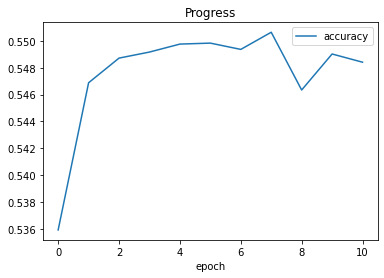

In [7]:
plot_training_session(parameters, plots=["accuracy"])

In [8]:
generate_name(model, parameters, start_char = 'j')

i=0 new_char: i (0.188) [best:  a (0.320), diff: 0.133, prob: 0.188, gap: 0.133]
i=1 new_char: l (0.146) [best:  l (0.146), diff: 0.000, prob: 0.027, gap: 0.133]
i=2 new_char: i (0.188) [best:  l (0.302), diff: 0.114, prob: 0.005, gap: 0.246]
i=3 new_char: c (0.067) [best:  e (0.178), diff: 0.111, prob: 0.000, gap: 0.358]
i=4 new_char: a (0.290) [best:  a (0.290), diff: 0.000, prob: 0.000, gap: 0.358]
i=5 new_char: * (0.797) [best:  * (0.797), diff: 0.000, prob: 0.000, gap: 0.358]
jilica (probs: 0.000080, gap: 0.357538)


('jilica', {'probability': 8.014910110420871e-05, 'gap': 0.35753782093524933})

In [9]:
generate_name(model, parameters)

i=0 new_char: s (0.034) [best:  c (0.175), diff: 0.141, prob: 0.034, gap: 0.141]
i=1 new_char: a (0.239) [best:  h (0.395), diff: 0.155, prob: 0.008, gap: 0.296]
i=2 new_char: l (0.136) [best:  r (0.241), diff: 0.105, prob: 0.001, gap: 0.401]
i=3 new_char: * (0.029) [best:  l (0.261), diff: 0.231, prob: 0.000, gap: 0.633]
sal (probs: 0.000033, gap: 0.632647)


('sal', {'probability': 3.25391994544028e-05, 'gap': 0.6326471120119095})

## different RNN types

----------------------------------------SimpleRNN----------------------------------------
Training took 17.07 seconds


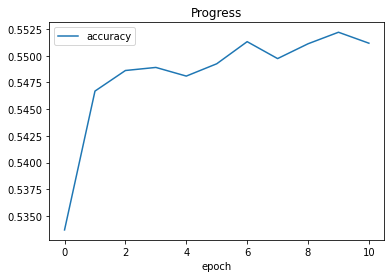

('jola', {'probability': 0.0019105884977866968, 'gap': 0.2818128243088722})
('bliamaen', {'probability': 1.9359977545654858e-10, 'gap': 2.041663445532322})
----------------------------------------LSTM----------------------------------------
Training took 27.81 seconds


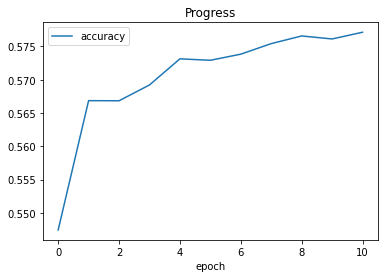

('jendissia', {'probability': 3.77100291281612e-07, 'gap': 1.2569909989833832})
('aythe', {'probability': 4.702473008778546e-07, 'gap': 0.7992770448327065})
----------------------------------------GRU----------------------------------------
Training took 27.29 seconds


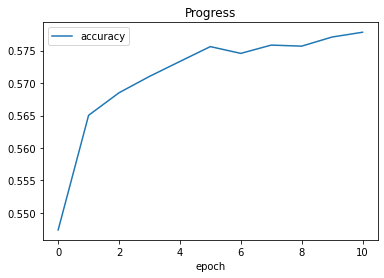

('jon', {'probability': 0.0023330283055710607, 'gap': 0.32688456773757935})
('oreda', {'probability': 7.116063103135852e-06, 'gap': 0.45525139570236206})


In [67]:
rnn_types = ['SimpleRNN', 'LSTM', 'GRU']
for rnn_type in rnn_types:
    print('-'*30 + rnn_type + '-'*30)
    parameters['rnn_type'] = rnn_type
    
    load_data(parameters)
    
    parameters["iter"] = 0
    parameters["total_epochs"] = 0
    parameters["history"] = {}

    model = create_model(parameters)
    compile_model(
        model,
        parameters
    )
    
    start = time.time()
    for i in range(len(parameters["epochs_to_run"])):
        train_model(model, parameters)
        parameters["iter"] = i
    end = time.time()
    print("Training took {0:.2f} seconds".format(end-start))
    
    plot_training_session(parameters, plots=["accuracy"])
    
    print(generate_name(model, parameters, start_char = 'j'))
    print(generate_name(model, parameters))

## different number of RNN units

----------------------------------------SimpleRNN (8)----------------------------------------
There is no data for val_accuracy
('juan', {'probability': 0.0012955802804701516, 'gap': 0.3469989001750946})
('duera', {'probability': 4.478784760974242e-06, 'gap': 0.8035126402974129})
----------------------------------------SimpleRNN (32)----------------------------------------
There is no data for val_accuracy
('je', {'probability': 0.03609012978733617, 'gap': 0.3058197498321533})
('ottette', {'probability': 1.747074330864626e-07, 'gap': 1.0806111544370651})
----------------------------------------SimpleRNN (64)----------------------------------------
There is no data for val_accuracy
('jtomte', {'probability': 2.7868226360845556e-06, 'gap': 0.9890207201242447})
('mimle', {'probability': 8.412929249170765e-05, 'gap': 0.5863882601261139})
----------------------------------------SimpleRNN (128)----------------------------------------
There is no data for val_accuracy
('jlaaahetaa', {'probabi

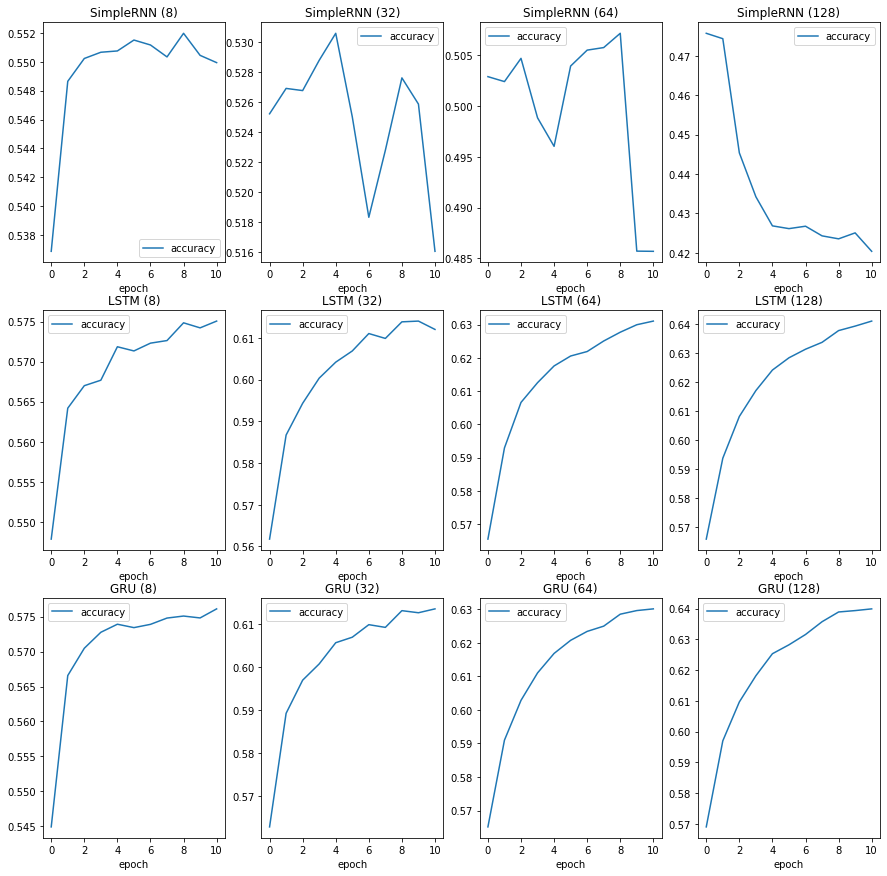

In [33]:
rnn_types = ['SimpleRNN', 'LSTM', 'GRU']
rnn_units = [8, 32, 64, 128]

plt.figure(1, figsize=(15, 15))

for index, (rnn_type, rnn_unit) in enumerate(itertools.product(rnn_types, rnn_units)):
    print('-'*30 + '{0} ({1})'.format(rnn_type, rnn_unit) + '-'*30)
    parameters['rnn_type'] = rnn_type
    parameters['rnn_units'] = rnn_unit
    
    load_data(parameters)
    
    parameters["iter"] = 0
    parameters["total_epochs"] = 0
    parameters["history"] = {}

    model = create_model(parameters)
    compile_model(
        model,
        parameters
    )

    for i in range(len(parameters["epochs_to_run"])):
        train_model(model, parameters)
        parameters["iter"] = i
    
    plt.subplot(len(rnn_types), len(rnn_units), index+1)
    plot_training_session(parameters, plots=["accuracy"], title='{0} ({1})'.format(rnn_type, rnn_unit), show=False)
    
    print(generate_name(model, parameters, start_char = 'j'))
    print(generate_name(model, parameters))
plt.show()

## regularization techniques (dropout / recurrent_dropout)

------------------------------dropout: 0.0, recurrent dropout: 0.0------------------------------
('je', {'probability': 0.00453466839787231, 'gap': 0.24160681664943695})
('marry', {'probability': 0.0002002204013326094, 'gap': 0.7730371803045273})
------------------------------dropout: 0.0, recurrent dropout: 0.1------------------------------
('jila', {'probability': 0.0001707590549149468, 'gap': 1.2866379022598267})
('esttie', {'probability': 5.519042582978982e-07, 'gap': 0.7833927497267723})
------------------------------dropout: 0.0, recurrent dropout: 0.3------------------------------
('jillise', {'probability': 0.0002964703838529009, 'gap': 0.7565038651227951})
('leegha', {'probability': 9.833008339778143e-07, 'gap': 0.5677347406744957})
------------------------------dropout: 0.0, recurrent dropout: 0.5------------------------------
('jodi', {'probability': 0.0006081216661187941, 'gap': 0.4457400031387806})
('co', {'probability': 1.735026584695037e-05, 'gap': 0.7333174273371696})
-

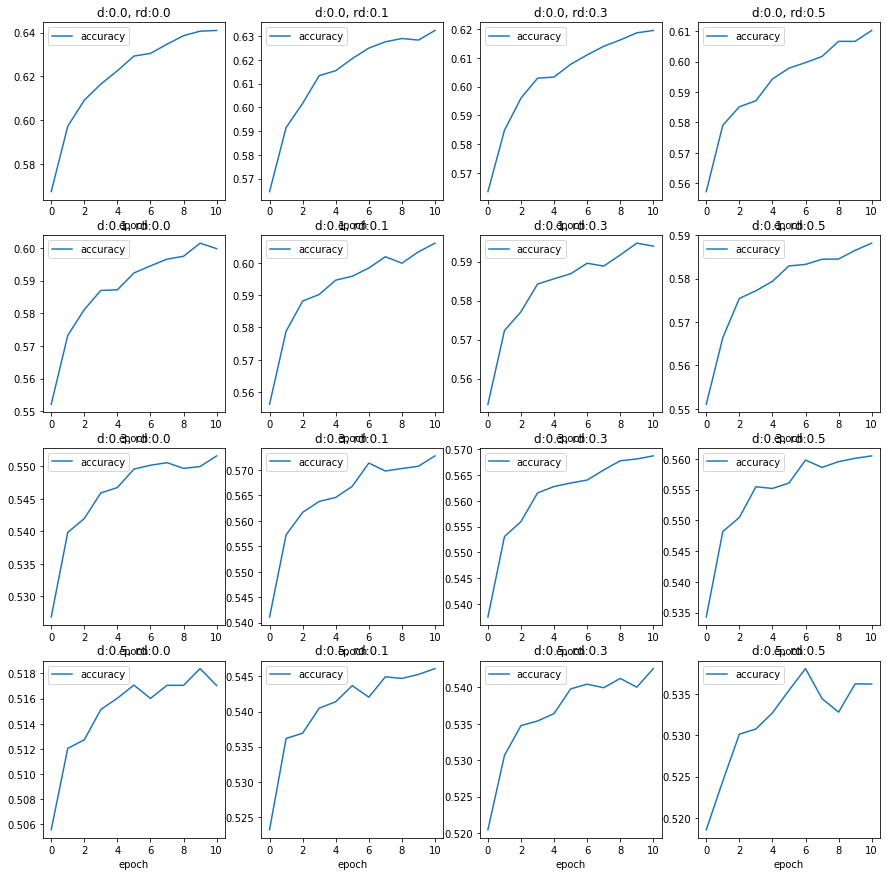

In [37]:
dropout_rates = [0.0, 0.1, 0.3, 0.5]

# use the same model, but change the regularization
parameters['rnn_type'] = 'GRU'
parameters['rnn_units'] = 128

plt.figure(1, figsize=(15, 15))

for index, (dropout, recurrent_dropout) in enumerate(itertools.product(dropout_rates, dropout_rates)):
    print('-'*30 + 'dropout: {0}, recurrent dropout: {1}'.format(dropout, recurrent_dropout) + '-'*30)
    parameters['dropout'] = dropout
    parameters['recurrent_dropout'] = recurrent_dropout
    
    load_data(parameters)
    
    parameters["iter"] = 0
    parameters["total_epochs"] = 0
    parameters["history"] = {}

    model = create_model(parameters)
    compile_model(
        model,
        parameters
    )

    for i in range(len(parameters["epochs_to_run"])):
        train_model(model, parameters)
        parameters["iter"] = i
    
    plt.subplot(len(dropout_rates), len(dropout_rates), index+1)
    plot_training_session(parameters, plots=["accuracy"], 
                          title='d:{0}, rd:{1}'.format(dropout, recurrent_dropout), show=False)
    
    print(generate_name(model, parameters, start_char = 'j'))
    print(generate_name(model, parameters))
plt.show()

## stack several RNN layers

------------------------------stack: 1------------------------------
('jerlyn', {'probability': 0.00010545051786796809, 'gap': 0.5042976886034012})
('seba', {'probability': 4.832784431570734e-05, 'gap': 0.8323830664157867})
------------------------------stack: 2------------------------------
('jacq', {'probability': 0.0035627286684215514, 'gap': 0.6574523150920868})
('fredrin', {'probability': 1.554890676568587e-06, 'gap': 0.7631334960460663})
------------------------------stack: 3------------------------------
('jordi', {'probability': 5.403019096503514e-05, 'gap': 0.39700864255428314})
('gora', {'probability': 0.00011282728137364283, 'gap': 0.292112834751606})
------------------------------stack: 4------------------------------
('j', {'probability': 0.03656831756234169, 'gap': 0.09605549275875092})
('geaie', {'probability': 1.5263965275358092e-06, 'gap': 0.20464716106653214})


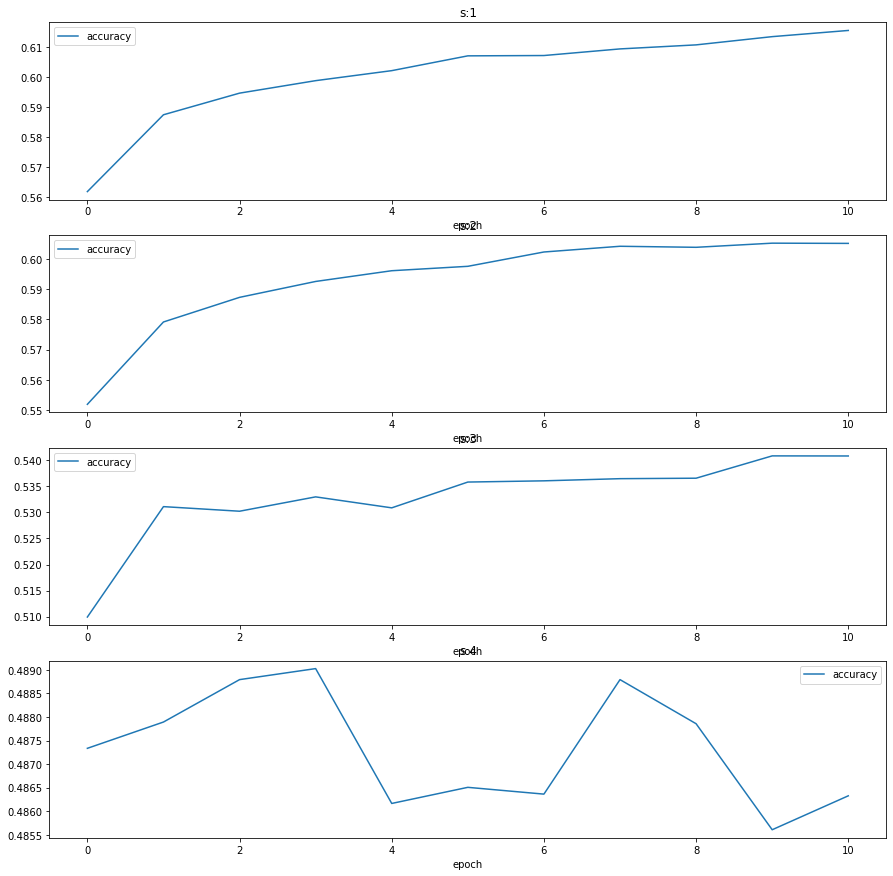

In [64]:
stacks = [1, 2, 3, 4]
base_unit = [64]

parameters['rnn_type'] = 'GRU'
parameters['dropout'] = 0.0
parameters['recurrent_dropout'] = 0.2

plt.figure(1, figsize=(15, 15))

for index, stack in enumerate(stacks):
    print('-'*30 + 'stack: {0}'.format(stack) + '-'*30)
    parameters['rnn_units'] = base_unit * stack
    
    load_data(parameters)
    
    parameters["iter"] = 0
    parameters["total_epochs"] = 0
    parameters["history"] = {}

    model = create_model(parameters)
    compile_model(
        model,
        parameters
    )

    for i in range(len(parameters["epochs_to_run"])):
        train_model(model, parameters)
        parameters["iter"] = i
    
    plt.subplot(len(stacks), 1, index+1)
    plot_training_session(parameters, plots=["accuracy"], 
                          title='s:{0}'.format(stack), show=False)
    
    print(generate_name(model, parameters, start_char = 'j'))
    print(generate_name(model, parameters))
plt.show()